In [9]:

import cv2
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

from skimage.segmentation._slic import _enforce_label_connectivity_cython

from libs.model import *
from libs.test import  assignment_test
import random
import time
random.seed(1)
torch.manual_seed(1)


In [18]:
class ARGS:
    def __init__(self):
        self.img_path = 'demo_imgs'
        self.check_path = './lnsnet_BSDS_checkpoint.pth'
        self.img_name = '107793.jpg'
        self.device = 'cpu'
        self.seed_strategy = 'network'
        self.n_spix = 100
        self.use_gal = True
        self.use_gbl = True
        self.is_dilation = True
        self.kn = 16

args = ARGS()

ipykernel_launcher:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
ipykernel_launcher:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


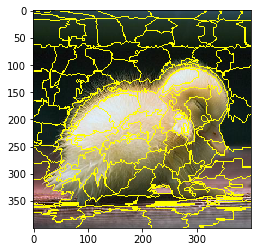

In [19]:
model = LNSN(args.n_spix, args)

model.load_state_dict(torch.load(args.check_path))

img = plt.imread(args.img_path + "/" + args.img_name)
input = preprocess(img, args.device)


with torch.no_grad():
    start = time.clock()
    
    b, _, h, w = input.size()
    recons, cx, cy, f, probs = model.forward(input, torch.zeros(h, w))
    spix = assignment_test(f, input, cx, cy) 

    spix = spix.permute(0, 2, 1).contiguous().view(b, -1, h, w)
    spix = spix.argmax(1).squeeze().to("cpu").detach().numpy()

    end = time.clock()
    t = end - start
segment_size = spix.size / args.n_spix
min_size = int(0.06 * segment_size)
max_size = int(3.0 * segment_size)
spix = _enforce_label_connectivity_cython(spix[None], min_size, max_size)[0]
if img.shape[:2] != spix.shape[-2:]:
    spix = spix.transpose(1, 0)

write_img= mark_boundaries(img, spix)
plt.figure(); plt.imshow(write_img)